<a href="https://colab.research.google.com/github/awaegli/AriRazi-/blob/master/TransferLearning_TF2_beta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Tutorial
# Fine-Tuning

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

We have previously seen in Tutorials #08 and #09 how to use a pre-trained Neural Network on a new dataset using so-called Transfer Learning, by re-routing the output of the original model just prior to its classification layers and instead use a new classifier that we had created. Because the original model was 'frozen' its weights could not be further optimized, so whatever had been learned by all the previous layers in the model, could not be fine-tuned to the new data-set.

This tutorial shows how to do both Transfer Learning and Fine-Tuning using the Keras API for Tensorflow. We will once again use the Knifey-Spoony dataset introduced in Tutorial #09. We previously used the Inception v3 model but we will use the VGG16 model in this tutorial because its architecture is easier to work with.

NOTE: It takes around 15 minutes to execute this Notebook on a laptop PC with a 2.6 GHz CPU and a GTX 1070 GPU. Running it on the CPU alone is estimated to take around 10 hours!

## Flowchart

The idea is to re-use a pre-trained model, in this case the VGG16 model, which consists of several convolutional layers (actually blocks of multiple convolutional layers), followed by some fully-connected / dense layers and then a softmax output layer for the classification. 

The dense layers are responsible for combining features from the convolutional layers and this helps in the final classification. So when the VGG16 model is used on another dataset we may have to replace all the dense layers. In this case we add another dense-layer and a dropout-layer to avoid overfitting.

The difference between Transfer Learning and Fine-Tuning is that in Transfer Learning we only optimize the weights of the new classification layers we have added, while we keep the weights of the original VGG16 model. In Fine-Tuning we optimize both the weights of the new classification layers we have added, as well as some or all of the layers from the VGG16 model.

![Flowchart of Transfer Learning & Fine-Tuning](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/10_transfer_learning_flowchart.png?raw=1)

## Imports

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os

These are the imports from the Keras API. Note the long format which can hopefully be shortened in the future to e.g. `from tf.keras.models import Model`.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install -q tensorflow-gpu==2.0.0-beta1


     |████████████████████████████████| 348.9MB 54kB/s 
     |████████████████████████████████| 3.1MB 32.2MB/s 
     |████████████████████████████████| 501kB 39.7MB/s 


In [0]:
import tensorflow as tf


from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop

This was developed using Python 3.6 and TensorFlow version:

In [8]:
tf.__version__

'2.0.0-beta1'

## Helper Functions

### Helper-function for joining a directory and list of filenames.

In [0]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

### Helper-function for plotting images

Function used to plot at most 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [0]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(15,15))
                             

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for printing confusion matrix

In [0]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

### Helper-function for plotting example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [0]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

Function for calculating the predicted classes of the entire test-set and calling the above function to plot a few examples of mis-classified images.

In [0]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

### Helper-function for loading images

The data-set is not loaded into memory, instead it has a list of the files for the images in the training-set and another list of the files for the images in the test-set. This helper-function loads some image-files.

In [0]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

### Helper-function for plotting training history

This plots the classification accuracy and loss-values recorded during training with the Keras API.

In [0]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

## Dataset: Knifey-Spoony

Download the Knifey dataset and move it on your google drive storage.


Connect Colab with Google drive:

In [19]:
from google.colab import drive
drive.mount('/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Define the directories where your images are stored.

In [0]:
train_dir = '/gdrive/My Drive/Colab Notebooks/train'
test_dir = '/gdrive/My Drive/Colab Notebooks/test'

## Pre-Trained Model: VGG16

The following creates an instance of the pre-trained VGG16 model using the Keras API. This automatically downloads the required files if you don't have them already. Note how simple this is in Keras compared to Tutorial #08.

The VGG16 model contains a convolutional part and a fully-connected (or dense) part which is used for classification. If `include_top=True` then the whole VGG16 model is downloaded which is about 528 MB. If `include_top=False` then only the convolutional part of the VGG16 model is downloaded which is just 57 MB.

We will try and use the pre-trained model for predicting the class of some images in our new dataset, so we have to download the full model, but if you have a slow internet connection, then you can modify the code below to use the smaller pre-trained model without the classification layers.

In [21]:
model = VGG16(include_top=True, weights='imagenet')

553467904/553467096 [==============================] - 7s 0us/step


## Input Pipeline

The Keras API has its own way of creating the input pipeline for training a model using files.

First we need to know the shape of the tensors expected as input by the pre-trained VGG16 model. In this case it is images of shape 224 x 224 x 3.

In [77]:
input_shape = model.layers[0].output_shape[0][1:3]
input_shape

(224, 224)

Keras uses a so-called data-generator for inputting data into the neural network, which will loop over the data for eternity.

We have a small training-set so it helps to artificially inflate its size by making various transformations to the images. We use a built-in data-generator that can make these random transformations. This is also called an augmented dataset.

In [0]:
datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

We also need a data-generator for the test-set, but this should not do any transformations to the images because we want to know the exact classification accuracy on those specific images. So we just rescale the pixel-values so they are between 0.0 and 1.0 because this is expected by the VGG16 model.

In [0]:
datagen_test = ImageDataGenerator(rescale=1./255)

The data-generators will return batches of images. Because the VGG16 model is so large, the batch-size cannot be too large, otherwise you will run out of RAM on the GPU.

In [0]:
batch_size = 10

We can save the randomly transformed images during training, so as to inspect whether they have been overly distorted, so we have to adjust the parameters for the data-generator above.

In [0]:
if True:
    save_to_dir = None
else:
    save_to_dir='augmented_images/'

Now we create the actual data-generator that will read files from disk, resize the images and return a random batch.

It is somewhat awkward that the construction of the data-generator is split into these two steps, but it is probably because there are different kinds of data-generators available for different data-types (images, text, etc.) and sources (memory or disk).

In [85]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir)

Found 4170 images belonging to 3 classes.


The data-generator for the test-set should not transform and shuffle the images.

In [33]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 530 images belonging to 3 classes.


Because the data-generators will loop for eternity, we need to specify the number of steps to perform during evaluation and prediction on the test-set. Because our test-set contains 530 images and the batch-size is set to 20, the number of steps is 26.5 for one full processing of the test-set. This is why we need to reset the data-generator's counter in the `example_errors()` function above, so it always starts processing from the beginning of the test-set.

This is another slightly awkward aspect of the Keras API which could perhaps be improved.

In [34]:
steps_test = generator_test.n / batch_size
steps_test

53.0

Get the file-paths for all the images in the training- and test-sets.

In [0]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

Get the class-numbers for all the images in the training- and test-sets.

In [0]:
cls_train = generator_train.classes
cls_test = generator_test.classes

Get the class-names for the dataset.

In [37]:
class_names = list(generator_train.class_indices.keys())
class_names

['forky', 'knifey', 'spoony']

Get the number of classes for the dataset.

In [38]:
num_classes = generator_train.num_classes
num_classes

3

### Plot a few images to see if data is correct

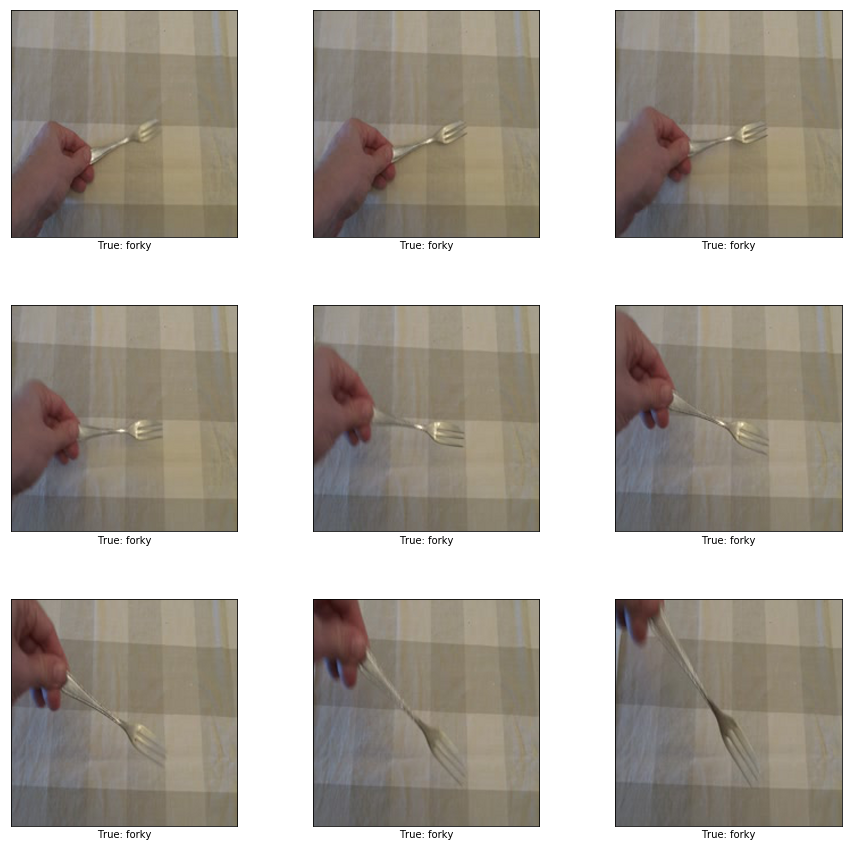

In [46]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

### Class Weights

The Knifey-Spoony dataset is quite imbalanced because it has few images of forks, more images of knives, and many more images of spoons. This can cause a problem during training because the neural network will be shown many more examples of spoons than forks, so it might become better at recognizing spoons.

Here we use scikit-learn to calculate weights that will properly balance the dataset. These weights are applied to the gradient for each image in the batch during training, so as to scale their influence on the overall gradient for the batch.

In [0]:
from sklearn.utils.class_weight import compute_class_weight

In [0]:
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

Note how the weight is about 1.398 for the forky-class and only 0.707 for the spoony-class. This is because there are fewer images for the forky-class so the gradient should be amplified for those images, while the gradient should be lowered for spoony-images.

In [0]:
class_weight

array([1.39839034, 1.14876033, 0.70701933])

In [49]:
class_names

['forky', 'knifey', 'spoony']

## Example Predictions

Here we will show a few examples of using the pre-trained VGG16 model for prediction.

We need a helper-function for loading and resizing an image so it can be input to the VGG16 model, as well as doing the actual prediction and showing the result.

In [0]:
def predict(image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    print('input_shape')
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Use the VGG16 model to make a prediction.
    # This outputs an array with 1000 numbers corresponding to
    # the classes of the ImageNet-dataset.
    pred = model.predict(img_array)
    
    # Decode the output of the VGG16 model.
    pred_decoded = decode_predictions(pred)[0]

    # Print the predictions.
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

We can then use the VGG16 model on a picture of a parrot which is classified as a macaw (a parrot species) with a fairly high score of 79%.

We can then use the VGG16 model to predict the class of one of the images in our new training-set. The VGG16 model is very confused about this image and cannot make a good classification.

input_shape


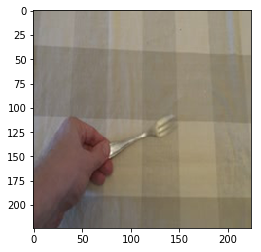

40960/35363 [==================================] - 0s 0us/step
50.31% : shower_curtain
17.08% : handkerchief
12.75% : mosquito_net
 2.87% : window_shade
 1.32% : toilet_tissue


In [52]:
predict(image_path=image_paths_train[0])

We can try it for another image in our new training-set and the VGG16 model is still confused.

input_shape


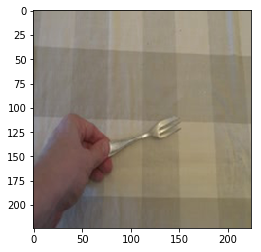

45.08% : shower_curtain
21.84% : mosquito_net
11.55% : handkerchief
 2.02% : window_shade
 0.91% : Windsor_tie


In [53]:
predict(image_path=image_paths_train[1])

We can also try an image from our new test-set, and again the VGG16 model is very confused.

input_shape


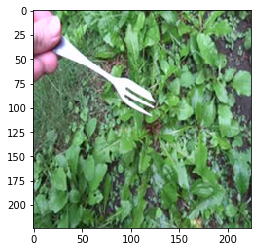

26.75% : spoonbill
 7.06% : black_stork
 7.04% : wooden_spoon
 4.21% : limpkin
 3.72% : paddle


In [54]:
predict(image_path=image_paths_test[0])

## Transfer Learning

The pre-trained VGG16 model was unable to classify images from the Knifey-Spoony dataset. The reason is perhaps that the VGG16 model was trained on the so-called ImageNet dataset which may not have contained many images of cutlery.

The lower layers of a Convolutional Neural Network can recognize many different shapes or features in an image. It is the last few fully-connected layers that combine these featuers into classification of a whole image. So we can try and re-route the output of the last convolutional layer of the VGG16 model to a new fully-connected neural network that we create for doing classification on the Knifey-Spoony dataset.

First we print a summary of the VGG16 model so we can see the names and types of its layers, as well as the shapes of the tensors flowing between the layers. This is one of the major reasons we are using the VGG16 model in this tutorial, because the Inception v3 model has so many layers that it is confusing when printed out.

In [55]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

We can see that the last convolutional layer is called 'block5_pool' so we use Keras to get a reference to that layer.

In [0]:
transfer_layer = model.get_layer('block5_pool')

We refer to this layer as the Transfer Layer because its output will be re-routed to our new fully-connected neural network which will do the classification for the Knifey-Spoony dataset.

The output of the transfer layer has the following shape:

In [57]:
transfer_layer.output

<tf.Tensor 'block5_pool/Identity:0' shape=(None, 7, 7, 512) dtype=float32>

Using the Keras API it is very simple to create a new model. First we take the part of the VGG16 model from its input-layer to the output of the transfer-layer. We may call this the convolutional model, because it consists of all the convolutional layers from the VGG16 model.

In [0]:
conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

We can then use Keras to build a new model on top of this.

In [0]:
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add the final layer for the actual classification.
new_model.add(Dense(num_classes, activation='softmax'))

We use the Adam optimizer with a fairly low learning-rate. The learning-rate could perhaps be larger. But if you try and train more layers of the original VGG16 model, then the learning-rate should be quite low otherwise the pre-trained weights of the VGG16 model will be distorted and it will be unable to learn.

In [0]:
optimizer = Adam(lr=1e-5)

We have 3 classes in the Knifey-Spoony dataset so Keras needs to use this loss-function.

In [0]:
loss = 'categorical_crossentropy'

The only performance metric we are interested in is the classification accuracy.

In [0]:
metrics = ['categorical_accuracy']

Helper-function for printing whether a layer in the VGG16 model should be trained.

In [0]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

By default all the layers of the VGG16 model are trainable.

In [65]:
print_layer_trainable()

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In Transfer Learning we are initially only interested in reusing the pre-trained VGG16 model as it is, so we will disable training for all its layers.

In [0]:
conv_model.trainable = False

In [0]:
for layer in conv_model.layers:
    layer.trainable = False

In [68]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


Once we have changed whether the model's layers are trainable, we need to compile the model for the changes to take effect.

In [0]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

An epoch normally means one full processing of the training-set. But the data-generator that we created above, will produce batches of training-data for eternity. So we need to define the number of steps we want to run for each "epoch" and this number gets multiplied by the batch-size defined above. In this case we have 100 steps per epoch and a batch-size of 20, so the "epoch" consists of 2000 random images from the training-set. We run 20 such "epochs".

The reason these particular numbers were chosen, was because they seemed to be sufficient for training with this particular model and dataset, and it didn't take too much time, and resulted in 20 data-points (one for each "epoch") which can be plotted afterwards.

In [0]:
epochs = 10
steps_per_epoch = 100

Training the new model is just a single function call in the Keras API. This takes about 6-7 minutes on a GTX 1070 GPU.

In [86]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 1/10


W0627 14:11:11.219358 140414086227840 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100/100 [==============================] - 272s 3s/step - loss: 1.1977 - categorical_accuracy: 0.4410 - val_loss: 0.9083 - val_categorical_accuracy: 0.5981
Epoch 2/10
100/100 [==============================] - 162s 2s/step - loss: 1.0266 - categorical_accuracy: 0.4980 - val_loss: 0.7583 - val_categorical_accuracy: 0.7340
Epoch 3/10
100/100 [==============================] - 196s 2s/step - loss: 0.9384 - categorical_accuracy: 0.5440 - val_loss: 0.6824 - val_categorical_accuracy: 0.7623
Epoch 4/10
100/100 [==============================] - 179s 2s/step - loss: 0.8670 - categorical_accuracy: 0.5860 - val_loss: 0.6858 - val_categorical_accuracy: 0.7415
Epoch 5/10
100/100 [==============================] - 50s 502ms/step - loss: 0.8309 - categorical_accuracy: 0.6180 - val_loss: 0.6827 - val_categorical_accuracy: 0.7698
Epoch 6/10
100/100 [==============================] - 29s 286ms/step - loss: 0.7662 - categorical_accuracy: 0.6640 - val_loss: 0.6425 - val_categorical_accuracy: 0.7906
Epoch

Keras records the performance metrics at the end of each "epoch" so they can be plotted later. This shows that the loss-value for the training-set generally decreased during training, but the loss-values for the test-set were a bit more erratic. Similarly, the classification accuracy generally improved on the training-set while it was a bit more erratic on the test-set.

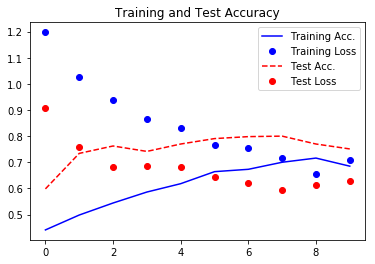

In [87]:
plot_training_history(history)

After training we can also evaluate the new model's performance on the test-set using a single function call in the Keras API.

In [0]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

In [89]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 75.09%


We can plot some examples of mis-classified images from the test-set. Some of these images are also difficult for a human to classify.

The confusion matrix shows that the new model is especially having problems classifying the forky-class.

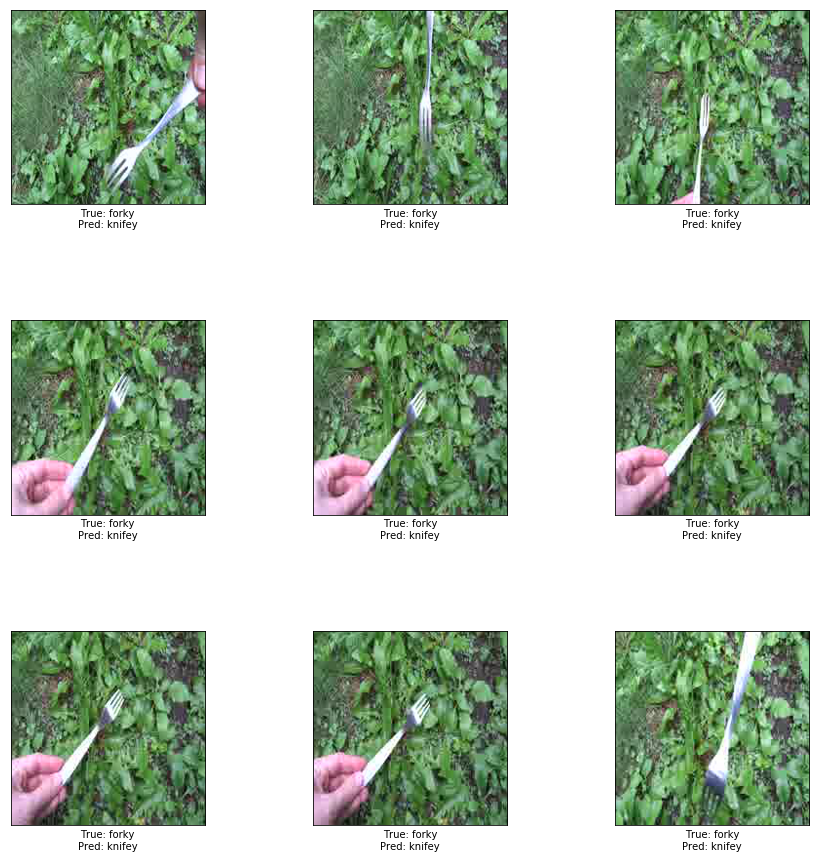

Confusion matrix:
[[126  25   0]
 [ 27 109   1]
 [ 61  18 163]]
(0) forky
(1) knifey
(2) spoony


In [90]:
example_errors()

## Fine-Tuning

In Transfer Learning the original pre-trained model is locked or frozen during training of the new classifier. This ensures that the weights of the original VGG16 model will not change. One advantage of this, is that the training of the new classifier will not propagate large gradients back through the VGG16 model that may either distort its weights or cause overfitting to the new dataset.

But once the new classifier has been trained we can try and gently fine-tune some of the deeper layers in the VGG16 model as well. We call this Fine-Tuning.

It is a bit unclear whether Keras uses the `trainable` boolean in each layer of the original VGG16 model or if it is overrided by the `trainable` boolean in the "meta-layer" we call `conv_layer`. So we will enable the `trainable` boolean for both `conv_layer` and all the relevant layers in the original VGG16 model.

In [0]:
conv_model.trainable = True

We want to train the last two convolutional layers whose names contain 'block5' or 'block4'.

In [0]:
for layer in conv_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable

We can check that this has updated the `trainable` boolean for the relevant layers.

In [93]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


We will use a lower learning-rate for the fine-tuning so the weights of the original VGG16 model only get changed slowly.

In [0]:
optimizer_fine = Adam(lr=1e-7)

Because we have defined a new optimizer and have changed the `trainable` boolean for many of the layers in the model, we need to recompile the model so the changes can take effect before we continue training.

In [0]:
new_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

The training can then be continued so as to fine-tune the VGG16 model along with the new classifier.

In [96]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 1/10
100/100 [==============================] - 38s 379ms/step - loss: 0.6620 - categorical_accuracy: 0.7160 - val_loss: 0.5844 - val_categorical_accuracy: 0.7830
Epoch 2/10
100/100 [==============================] - 35s 350ms/step - loss: 0.6455 - categorical_accuracy: 0.7390 - val_loss: 0.5731 - val_categorical_accuracy: 0.7906
Epoch 3/10
100/100 [==============================] - 35s 350ms/step - loss: 0.5909 - categorical_accuracy: 0.7570 - val_loss: 0.5743 - val_categorical_accuracy: 0.7906
Epoch 4/10
100/100 [==============================] - 35s 353ms/step - loss: 0.6224 - categorical_accuracy: 0.7390 - val_loss: 0.5709 - val_categorical_accuracy: 0.7943
Epoch 5/10
100/100 [==============================] - 35s 353ms/step - loss: 0.6240 - categorical_accuracy: 0.7330 - val_loss: 0.5628 - val_categorical_accuracy: 0.7962
Epoch 6/10
100/100 [==============================] - 35s 350ms/step - loss: 0.6114 - categorical_accuracy: 0.7450 - val_loss: 0.5644 - val_categorical_acc

We can then plot the loss-values and classification accuracy from the training. Depending on the dataset, the original model, the new classifier, and hyper-parameters such as the learning-rate, this may improve the classification accuracies on both training- and test-set, or it may improve on the training-set but worsen it for the test-set in case of overfitting. It may require some experimentation with the parameters to get this right.

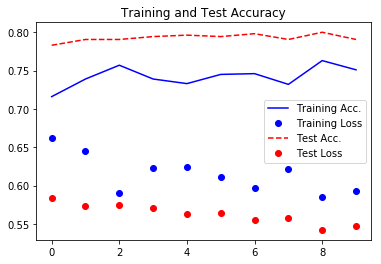

In [97]:
plot_training_history(history)

In [0]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

In [99]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 79.06%


We can plot some examples of mis-classified images again, and we can also see from the confusion matrix that the model is still having problems classifying forks correctly.

A part of the reason might be that the training-set contains only 994 images of forks, while it contains 1210 images of knives and 1966 images of spoons. Even though we have weighted the classes to compensate for this imbalance, and we have also augmented the training-set by randomly transforming the images in different ways during training, it may not be enough for the model to properly learn to recognize forks.

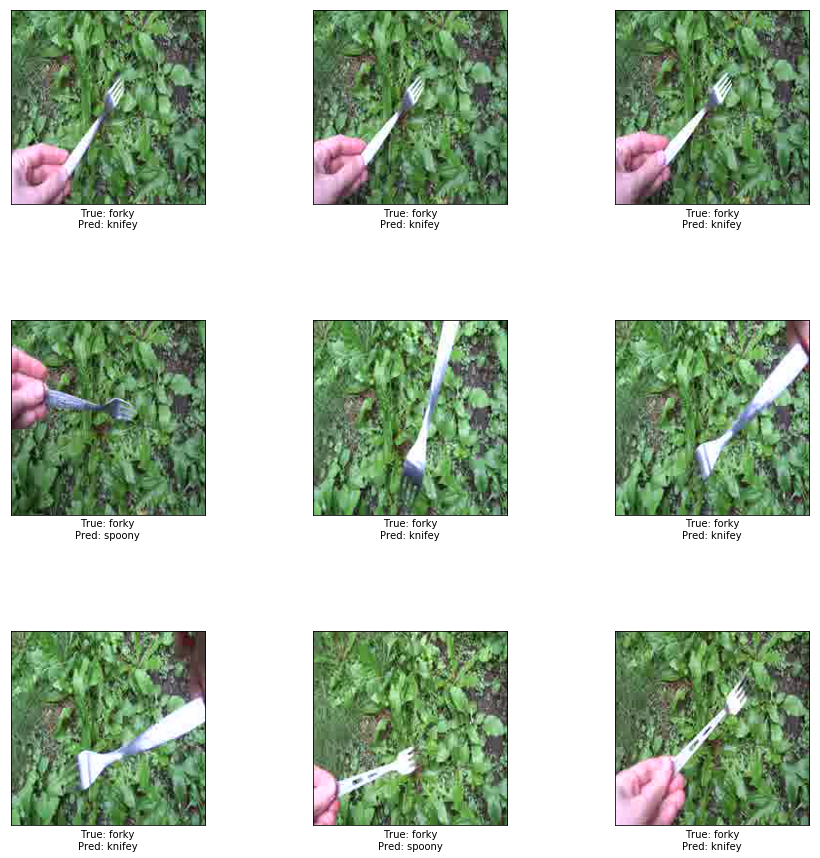

Confusion matrix:
[[141   8   2]
 [ 45  90   2]
 [ 48   6 188]]
(0) forky
(1) knifey
(2) spoony


In [100]:
example_errors()

## Conclusion

This tutorial showed how to use the Keras API for TensorFlow to do both Transfer Learning and Fine-Tuning of the pre-trained VGG16 model on a new dataset. It is much easier to implement this using the Keras API rather than directly in TensorFlow.

Whether Fine-Tuning improves the classification accuracy over just using Transfer Learning depends on the pre-trained model, the transfer-layer you choose, your dataset, and how you train the new model. You may experience improved performance from the fine-tuning, or you may experience worse performance if the fine-tuned model is overfitting your training-data.

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook and the other files before making any changes.

* Try using other layers in the VGG16 model as the transfer layer. How does it affect the training and classification accuracy?
* Change the new classification layers we added. Can you improve the classification accuracy by either increasing or decreasing the number of nodes in the fully-connected / dense layer?
* What happens if you remove the Dropout-layer in the new classifier?
* Change the learning-rates for both Transfer Learning and Fine-Tuning.
* Try fine-tuning on the whole VGG16 model instead of just the last few layers. How does it affect the classification accuracy on the training- and test-sets? Why?
* Try doing the fine-tuning from the beginning so the new classification layers are trained from scratch along with all the convolutional layers of the VGG16 model. You may need to lower the learning-rate for the optimizer.
* Add a few images from the test-set to the training-set. Does that improve performance?
* Try deleting some of the knifey and spoony images from the training-set so the classes all have the same number of images. Does that improve the numbers in the confusion-matrix?
* Use another dataset.
* Use another pre-trained model available from Keras.
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2016-2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.